### ALGORITHM

TRAINING
1. Generate a noisy sprite
2. Choose the closest goal sprite from the training data (hamming distance)
3. Destroy the goal sprite (sequentially over pixles) until it matches the noisy sprite
4. Add the level repair step to the training data
5. Repeat until it matches the noise

---

GENERATION 
1. Initialize a noisy sprite
2. Randomly or sequentially pick/fix a pixel
3. Feed the level into the network to output a repair value
4. Update the pixel with the value
5. If the current sprite isn't valid, keep going

### Imports and Configuration

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from tqdm import tqdm

# tensorflow
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, Conv2DTranspose, Flatten, Layer, Reshape, Input, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model


%matplotlib inline

2023-04-20 17:59:41.219135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#import from Python folder to get the utils
import sys
sys.path.append('../Python')
from utils import picoSS2np, showMultiSprPalette, showMultiSprRGB, showSprRGB, showSprPalette, animatePal

/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
### CONSTANT VARIABLES   ###

# PICO-8 Palette => use colormap for matplotlib
PICO_PALETTE = ['#000000','#1D2B53','#7E2553','#008751','#AB5236','#5F574F','#C2C3C7','#FFF1E8','#FF004D','#FFA300','#FFEC27','#00E436','#29ADFF','#83769C','#FF77A8','#FFCCAA']


Food Dataset shape: (100, 8, 8)
Char Dataset shape: (100, 8, 8)


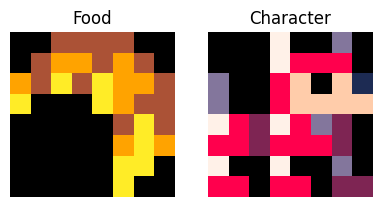

In [6]:
# import from the PICO sprites posted onto Twitter 
# Food: https://twitter.com/JUSTIN_CYR/status/634546317713391616
# Characters: https://twitter.com/johanvinet/status/635814153601597441
pico_food_dat = np.load('../data/rip_data/pico_food.npy',allow_pickle=True)
pico_char_dat = np.load('../data/rip_data/pico_characters.npy',allow_pickle=True)

print(f"Food Dataset shape: {pico_food_dat.shape}")
print(f"Char Dataset shape: {pico_char_dat.shape}")

# show a random food and character sprite 
rand_food = random.choice(pico_food_dat)
rand_char = random.choice(pico_char_dat)
showMultiSprPalette([rand_food,rand_char],textArr=['Food','Character'])

In [53]:
###   CONFIUGURATIONS   ###

EXPERIMENT = "normal"

GEN_CONF = {
    "EPOCHS" : 50,
    "BATCH_SIZE" : 64,
    "LEARNING_RATE" : 0.0001,
    "WINDOW" : 4
}

CONFIGS = {
    "normal": {
        "NEW_TRAIN_DAT" : True,
        "TRAIN_DAT_PATH" : f'../data/rip_data/POD_train_dat_w{GEN_CONF["WINDOW"]}.npy',
        "TRAIN_NPOD" : True,
        "NPOD_MODEL" : f"../models/gen_models/pod/npod_char-{GEN_CONF['EPOCHS']}eR_w{GEN_CONF['WINDOW']}.h5",
        "SANITY" : False
    }
}


### Normal PoD

---

#### Notes

[window size: 5]
[epochs: 50]
- Abstract art-esque - not quite character looking though

[window size: 8]
[epochs: 50]
- More character definition. Much more cohesive

[window size: 9]
[epochs: 50]
- Not much change but makes a 'character' at earlier iterations

[window size: 9 - TMNT edition]
[epochs: 10 (reached 98%)]
- perfectly recreates ninja turtles every time; can replace a tile with the same tile

[window size: 4]
[epochs: 50]




In [52]:
class NormalPoD():
    def __init__(self,spr_shape, channels=16, pad_val=0, crop_size=5):
        self.destroy_data = []
        self.spr_shape = spr_shape
        self.channels = channels
        self.pad_val = pad_val
        self.crop_size = crop_size

    # make a new noisy sprite using the channels and size
    def init_noise_sprite(self):
        noise_spr = np.random.randint(self.channels,size=(self.spr_shape[0],self.spr_shape[1]))
        return noise_spr

    # crop a sprite from the noise sprite (use with padding) - assume pos is (x,y) and center of target crop
    def crop(self, spr, pos, size=5):
        hpad = size//2
        pad_spr = np.pad(spr,((hpad,hpad),(hpad,hpad)),constant_values=self.pad_val)   # pad the sprite 
        crop_spr = pad_spr[pos[0]:pos[0]+size,pos[1]:pos[1]+size]   # get the cropped sprite (should be size,size)
        return pad_spr, crop_spr

    # return the new level and the tile replaced (also add to training data) - assume pos is (x,y)
    def destroy(self, cur_spr, bad_spr, pos, crop_size=5):
        # turn the cur_spr value at the pos to the bad_spr value
        cur_spr2 = np.copy(cur_spr)
        og_val = cur_spr[pos[0],pos[1]]
        cur_spr2[pos[0],pos[1]] = bad_spr[pos[0],pos[1]]

        # crop around the area and add to training data
        _, crop_spr = self.crop(cur_spr2,pos,crop_size)

        return cur_spr2, og_val, crop_spr
    
    # calculate the hamming distance from 2 sprites
    def calc_ham_dist(self, spr1, spr2):
        return np.sum(spr1 != spr2)

    # return the sprite that is closest in hamming distance from the goal set
    def closest_spr(self, goal_set, noise_spr):
        min_dist_i = np.argmin([self.calc_ham_dist(noise_spr, i) for i in goal_set])
        return goal_set[min_dist_i]

    
    # make the training data for the path of destruction
    def make_train_dat(self,goal_set,num_noise_spr=1000):
        train_dat = []
        with tqdm(total=num_noise_spr) as pbar:
            for i in range(num_noise_spr):
                # make a noise sprite and find the closest
                # noise_spr = self.init_noise_sprite()
                # targ_spr = self.closest_spr(goal_set,noise_spr).copy()

                #go through each goal sprite and make a noise sprite for it
                targ_spr = goal_set[i%len(goal_set)]
                noise_spr = self.init_noise_sprite()

                # make a list of all the positions in the sprite and shuffle it
                pos_set = []
                for x in range(self.spr_shape[0]):
                    for y in range(self.spr_shape[1]):
                        pos_set.append((x,y))
                random.shuffle(pos_set)

                # iterate over the goal sprite and change until it matches the noise spr (destroy)
                for p in pos_set:
                        # destroy the noise sprite
                        targ_spr, og_val, crop_spr = self.destroy(targ_spr,noise_spr,p,self.crop_size)
                        train_dat.append([crop_spr,og_val])
                        # showSprPalette(targ_spr)
                pbar.update(1)
                    
        return train_dat
    
    # make the path of destruction neural network model
    # copy of architecture from the paper [Conv(128,3) -> Conv(128,3) -> MaxPool(2), Conv(256,3)]
    # it doesn't work though... at least not with 5x5 crop size - need to ask Sam for exact implementation
    def makePoDCNN(self):
        self.pod_model = Sequential([
            InputLayer(input_shape=(self.crop_size,self.crop_size,1)),
            Conv2D(128, (3, 3), activation='relu',padding='SAME'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu',padding='SAME'),
            Conv2D(256, (3, 3), activation='relu',padding='SAME'),
            Flatten(),
            Dense(128),
            Dense(self.channels,activation='softmax'),
        ])
        self.pod_model.summary()
        self.opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        self.pod_model.compile(optimizer=self.opt,metrics=['accuracy'],loss='sparse_categorical_crossentropy') #not one-hot encoded
        
        
    # import a model from a path
    def importModel(self,model_path):
        self.pod_model = tf.keras.models.load_model(model_path)
        self.pod_model.summary()
        self.opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        self.pod_model.compile(optimizer=self.opt,metrics=['accuracy'],loss='sparse_categorical_crossentropy')


    # export the model to a path
    def exportModel(self,model_path):
        self.pod_model.save(model_path,save_format='h5')
                            

    # train the path of destruction model on the training data
    def trainPoD(self,train_dat,EPOCHS=500,BATCH_SIZE=64,show_acc=False):
        # train the model
        X = np.array([i[0] for i in train_dat])
        Y = np.array([i[1] for i in train_dat])
        X = np.expand_dims(X,axis=-1)
        Y = np.expand_dims(Y,axis=-1)
        print(X.shape,Y.shape)

        h = self.pod_model.fit(X,Y,epochs=EPOCHS,batch_size=BATCH_SIZE,shuffle=True)
        if show_acc:
            plt.plot(h.history['accuracy'])
            plt.show()

    # repair from a noise vector
    def repair(self,init_spr=None,mod_iter='rand',eval_met='iter',num_iter=1000,animate=False):
        # make a noise sprite
        if init_spr is None:
            init_spr = self.init_noise_sprite()
        cur_spr = np.copy(init_spr)

        if animate:
            anim_set = []
            anim_set.append(cur_spr)

        # iterate over the noise sprite and change until the iterations are done
        pi = 0
        if eval_met == "iter":
            with tqdm(total=num_iter) as pbar:
                for i in range(num_iter):
                    #select a position (randomly or sequentially)
                    if mod_iter == "rand":
                        x = np.random.randint(self.spr_shape[0])
                        y = np.random.randint(self.spr_shape[1])
                    else:
                        x = pi%self.spr_shape[0]
                        y = pi//self.spr_shape[0]
                        pi += 1
                        if pi >= self.spr_shape[0]*self.spr_shape[1]:
                            pi = 0

                    pbar.set_description("@ ({},{})".format(x,y))

                    #crop the area
                    _, crop_spr = self.crop(cur_spr,(x,y),self.crop_size)
                    
                    # get the pixel change input from the model
                    pred_px = self.pod_model.predict(np.array([crop_spr]),verbose=False)

                    # change the tile
                    cur_spr[x,y] = np.argmax(pred_px)

                    anim_set.append(cur_spr.copy())

                    pbar.update(1)

        if animate:
            return init_spr, cur_spr, anim_set
        return init_spr, cur_spr

if EXPERIMENT == "normal":
    # Make the Path of Destruction  model
    npod = NormalPoD((8,8),channels=16,crop_size=GEN_CONF['WINDOW'])     
    npod.makePoDCNN() 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 4, 4, 128)         1280      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 2, 2, 128)        0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 2, 2, 128)         147584    
                                                                 
 conv2d_23 (Conv2D)          (None, 2, 2, 256)         295168    
                                                                 
 flatten_7 (Flatten)         (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               131200    
                                                      

In [54]:
if EXPERIMENT == "normal":

    if CONFIGS["normal"]["NEW_TRAIN_DAT"]:
        # make the training data
        goal_spr_char = pico_char_dat.copy()
        train_dat = npod.make_train_dat(goal_spr_char,num_noise_spr=(len(goal_spr_char)*10))

        # ninja turtle set
        # turtle_spr_char = pico_char_dat[30:34]
        # showMultiSprPalette(turtle_spr_char)
        # train_dat = npod.make_train_dat(turtle_spr_char,num_noise_spr=(len(turtle_spr_char)*100))

        print(len(train_dat))

        # export as .npy file
        np.save(CONFIGS["normal"]["TRAIN_DAT_PATH"],train_dat)
    else:
        # import the training data
        train_dat = np.load(CONFIGS['normal']["TRAIN_DAT_PATH"],allow_pickle=True)
        print(len(train_dat))

100%|██████████| 1000/1000 [00:03<00:00, 282.38it/s]
/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


64000


(25600, 9, 9, 1) (25600, 1)
Epoch 1/10
800/800 [==============================] - 14s 16ms/step - loss: 0.4404 - accuracy: 0.8484
Epoch 2/10
800/800 [==============================] - 13s 16ms/step - loss: 0.1697 - accuracy: 0.9273
Epoch 3/10
800/800 [==============================] - 14s 17ms/step - loss: 0.1397 - accuracy: 0.9428
Epoch 4/10
800/800 [==============================] - 13s 16ms/step - loss: 0.1226 - accuracy: 0.9484
Epoch 5/10
800/800 [==============================] - 14s 17ms/step - loss: 0.1114 - accuracy: 0.9543
Epoch 6/10
800/800 [==============================] - 14s 17ms/step - loss: 0.1025 - accuracy: 0.9616
Epoch 7/10
800/800 [==============================] - 14s 17ms/step - loss: 0.0890 - accuracy: 0.9654
Epoch 8/10
800/800 [==============================] - 13s 16ms/step - loss: 0.0778 - accuracy: 0.9718
Epoch 9/10
800/800 [==============================] - 14s 17ms/step - loss: 0.0714 - accuracy: 0.9743
Epoch 10/10
800/800 [==============================] -

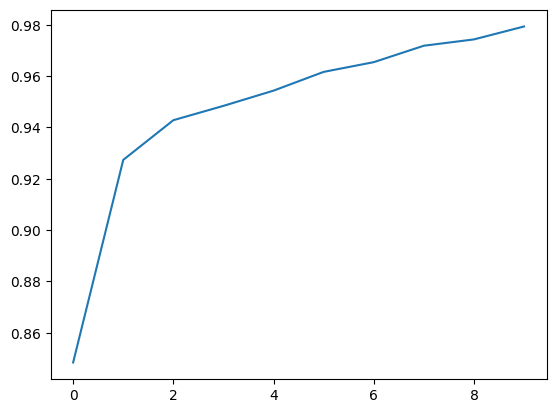

In [43]:
# train or import the model
if EXPERIMENT == "normal":
    if CONFIGS["normal"]["TRAIN_NPOD"]:
        npod.trainPoD(train_dat,EPOCHS=GEN_CONF['EPOCHS'],BATCH_SIZE=GEN_CONF['BATCH_SIZE'],show_acc=True)
        npod.exportModel(CONFIGS["normal"]["NPOD_MODEL"])
    else:
        npod.importModel(CONFIGS["normal"]["NPOD_MODEL"])

@ (2,6):   2%|▏         | 4/256 [00:00<00:15, 16.13it/s]

same pixel @ (5,0)!


@ (7,0):   7%|▋         | 18/256 [00:00<00:11, 21.13it/s]

same pixel @ (6,2)!
same pixel @ (0,4)!


@ (1,1):  11%|█         | 28/256 [00:01<00:10, 21.91it/s]

same pixel @ (4,7)!


@ (6,7):  14%|█▍        | 37/256 [00:01<00:09, 22.15it/s]

same pixel @ (0,1)!
same pixel @ (4,4)!


@ (6,1):  17%|█▋        | 43/256 [00:02<00:09, 21.98it/s]

same pixel @ (3,5)!
same pixel @ (4,3)!
same pixel @ (7,1)!
same pixel @ (3,6)!


@ (0,0):  19%|█▉        | 48/256 [00:02<00:09, 21.94it/s]

same pixel @ (6,1)!
same pixel @ (4,4)!
same pixel @ (2,3)!
same pixel @ (4,5)!


@ (3,4):  21%|██        | 54/256 [00:02<00:09, 21.82it/s]

same pixel @ (2,6)!
same pixel @ (3,6)!
same pixel @ (0,7)!


@ (5,1):  23%|██▎       | 60/256 [00:02<00:08, 22.00it/s]

same pixel @ (2,2)!
same pixel @ (1,6)!
same pixel @ (5,0)!
same pixel @ (1,5)!


@ (4,4):  26%|██▌       | 66/256 [00:03<00:09, 20.88it/s]

same pixel @ (4,2)!
same pixel @ (5,5)!
same pixel @ (4,2)!
same pixel @ (0,0)!


@ (2,1):  28%|██▊       | 71/256 [00:03<00:08, 20.93it/s]

same pixel @ (4,4)!
same pixel @ (5,4)!
same pixel @ (3,1)!
same pixel @ (4,2)!


@ (3,3):  30%|██▉       | 76/256 [00:03<00:08, 21.52it/s]

same pixel @ (2,1)!
same pixel @ (5,1)!
same pixel @ (7,7)!


@ (5,5):  32%|███▏      | 82/256 [00:03<00:08, 21.53it/s]

same pixel @ (4,0)!
same pixel @ (3,4)!
same pixel @ (2,1)!
same pixel @ (5,0)!


@ (3,7):  34%|███▍      | 87/256 [00:04<00:07, 21.79it/s]

same pixel @ (5,5)!
same pixel @ (0,1)!
same pixel @ (1,5)!
same pixel @ (1,2)!


@ (7,6):  37%|███▋      | 94/256 [00:04<00:07, 20.79it/s]

same pixel @ (1,5)!
same pixel @ (0,7)!
same pixel @ (6,2)!
same pixel @ (1,7)!
same pixel @ (1,0)!


@ (1,6):  39%|███▉      | 100/256 [00:04<00:07, 21.27it/s]

same pixel @ (4,7)!
same pixel @ (7,5)!
same pixel @ (1,4)!
same pixel @ (7,0)!
same pixel @ (1,6)!


@ (7,2):  41%|████      | 105/256 [00:04<00:07, 21.31it/s]

same pixel @ (1,6)!
same pixel @ (7,1)!
same pixel @ (3,7)!
same pixel @ (1,7)!
same pixel @ (3,3)!


@ (1,5):  43%|████▎     | 111/256 [00:05<00:06, 21.96it/s]

same pixel @ (1,6)!
same pixel @ (1,4)!
same pixel @ (1,5)!
same pixel @ (6,5)!
same pixel @ (0,2)!


@ (4,1):  45%|████▌     | 116/256 [00:05<00:06, 21.63it/s]

same pixel @ (1,5)!
same pixel @ (1,7)!
same pixel @ (4,5)!


@ (3,4):  48%|████▊     | 122/256 [00:05<00:06, 21.71it/s]

same pixel @ (2,2)!
same pixel @ (3,0)!
same pixel @ (0,7)!
same pixel @ (7,7)!
same pixel @ (5,5)!


@ (4,2):  50%|████▉     | 127/256 [00:05<00:05, 21.60it/s]

same pixel @ (3,4)!
same pixel @ (5,3)!
same pixel @ (1,6)!
same pixel @ (0,3)!
same pixel @ (6,2)!


@ (6,5):  51%|█████     | 131/256 [00:06<00:05, 21.69it/s]

same pixel @ (4,2)!
same pixel @ (2,2)!
same pixel @ (2,6)!
same pixel @ (2,5)!


@ (1,2):  53%|█████▎    | 136/256 [00:06<00:05, 20.69it/s]

same pixel @ (6,5)!
same pixel @ (7,7)!
same pixel @ (3,0)!
same pixel @ (6,7)!
same pixel @ (1,1)!


@ (6,1):  55%|█████▌    | 141/256 [00:06<00:05, 20.93it/s]

same pixel @ (1,2)!
same pixel @ (0,6)!
same pixel @ (7,0)!
same pixel @ (0,3)!


@ (1,1):  57%|█████▋    | 146/256 [00:06<00:05, 21.02it/s]

same pixel @ (6,1)!
same pixel @ (1,7)!
same pixel @ (1,2)!
same pixel @ (6,5)!
same pixel @ (0,2)!


@ (6,3):  59%|█████▉    | 151/256 [00:07<00:04, 21.24it/s]

same pixel @ (1,1)!
same pixel @ (5,5)!
same pixel @ (7,0)!
same pixel @ (0,7)!
same pixel @ (7,7)!


@ (1,4):  61%|██████    | 156/256 [00:07<00:04, 21.79it/s]

same pixel @ (6,3)!
same pixel @ (1,1)!
same pixel @ (0,5)!
same pixel @ (1,3)!


@ (6,0):  63%|██████▎   | 161/256 [00:07<00:04, 21.64it/s]

same pixel @ (1,4)!
same pixel @ (2,6)!
same pixel @ (6,1)!
same pixel @ (3,7)!


@ (6,2):  65%|██████▌   | 167/256 [00:07<00:04, 21.96it/s]

same pixel @ (5,6)!
same pixel @ (6,7)!
same pixel @ (3,4)!
same pixel @ (0,2)!
same pixel @ (3,6)!


@ (2,5):  67%|██████▋   | 172/256 [00:08<00:03, 21.58it/s]

same pixel @ (6,2)!
same pixel @ (3,5)!
same pixel @ (1,5)!
same pixel @ (7,1)!


@ (5,4):  69%|██████▉   | 176/256 [00:08<00:03, 21.80it/s]

same pixel @ (2,5)!
same pixel @ (0,3)!
same pixel @ (4,6)!
same pixel @ (6,5)!


@ (4,5):  71%|███████   | 181/256 [00:08<00:03, 21.00it/s]

same pixel @ (5,4)!
same pixel @ (2,1)!
same pixel @ (6,0)!
same pixel @ (0,4)!
same pixel @ (0,1)!


@ (1,3):  73%|███████▎  | 186/256 [00:08<00:03, 21.36it/s]

same pixel @ (4,5)!
same pixel @ (2,5)!
same pixel @ (4,5)!
same pixel @ (1,0)!
same pixel @ (6,7)!


@ (2,5):  75%|███████▍  | 191/256 [00:08<00:03, 21.29it/s]

same pixel @ (1,3)!
same pixel @ (2,3)!
same pixel @ (2,1)!
same pixel @ (2,2)!
same pixel @ (7,5)!


@ (4,0):  77%|███████▋  | 196/256 [00:09<00:02, 21.23it/s]

same pixel @ (2,5)!
same pixel @ (0,5)!
same pixel @ (6,7)!
same pixel @ (1,1)!
same pixel @ (5,5)!


@ (0,4):  79%|███████▊  | 201/256 [00:09<00:02, 21.88it/s]

same pixel @ (4,0)!
same pixel @ (4,4)!
same pixel @ (6,7)!
same pixel @ (3,1)!
same pixel @ (1,7)!


@ (7,7):  80%|████████  | 206/256 [00:09<00:02, 21.52it/s]

same pixel @ (0,4)!
same pixel @ (4,4)!
same pixel @ (1,3)!
same pixel @ (3,0)!
same pixel @ (1,5)!


@ (2,5):  82%|████████▏ | 211/256 [00:09<00:02, 21.84it/s]

same pixel @ (7,7)!
same pixel @ (3,1)!
same pixel @ (1,4)!
same pixel @ (0,4)!
same pixel @ (1,4)!


@ (7,1):  84%|████████▍ | 215/256 [00:10<00:01, 20.86it/s]

same pixel @ (2,5)!
same pixel @ (5,6)!
same pixel @ (6,2)!
same pixel @ (2,2)!


@ (2,5):  86%|████████▌ | 219/256 [00:10<00:01, 20.05it/s]

same pixel @ (7,1)!
same pixel @ (7,3)!
same pixel @ (0,1)!
same pixel @ (4,7)!


@ (7,3):  87%|████████▋ | 223/256 [00:10<00:01, 19.09it/s]

same pixel @ (2,5)!
same pixel @ (1,4)!
same pixel @ (0,7)!
same pixel @ (7,3)!


@ (7,5):  89%|████████▉ | 228/256 [00:10<00:01, 20.38it/s]

same pixel @ (7,3)!
same pixel @ (7,2)!
same pixel @ (1,1)!
same pixel @ (0,0)!


@ (6,5):  91%|█████████ | 233/256 [00:10<00:01, 20.28it/s]

same pixel @ (7,5)!
same pixel @ (5,5)!
same pixel @ (3,1)!
same pixel @ (5,7)!
same pixel @ (3,5)!


@ (7,3):  93%|█████████▎| 238/256 [00:11<00:00, 20.49it/s]

same pixel @ (6,5)!
same pixel @ (5,3)!
same pixel @ (6,0)!
same pixel @ (3,6)!
same pixel @ (1,1)!


@ (2,0):  95%|█████████▍| 243/256 [00:11<00:00, 21.37it/s]

same pixel @ (7,3)!
same pixel @ (5,6)!
same pixel @ (6,2)!
same pixel @ (7,5)!
same pixel @ (5,0)!


@ (1,4):  97%|█████████▋| 248/256 [00:11<00:00, 21.51it/s]

same pixel @ (2,0)!
same pixel @ (5,0)!
same pixel @ (6,3)!
same pixel @ (3,3)!


@ (3,2):  99%|█████████▉| 253/256 [00:11<00:00, 21.66it/s]

same pixel @ (1,4)!
same pixel @ (0,4)!
same pixel @ (7,0)!
same pixel @ (3,2)!
same pixel @ (4,6)!


@ (4,1): 100%|██████████| 256/256 [00:12<00:00, 21.18it/s]


same pixel @ (3,2)!
same pixel @ (5,2)!
same pixel @ (4,1)!


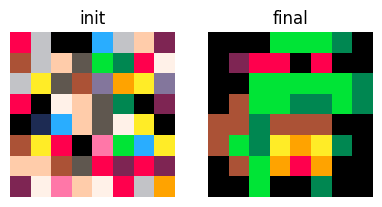

saving GIF 257...: 100%|██████████| 257/257 [00:13<00:00, 19.69it/s]


In [45]:
# show the output from repairing a noise sprite
if EXPERIMENT == "normal":
    init_spr, cur_spr, anims = npod.repair(mod_iter='rand',num_iter=256,animate=True)
    showMultiSprPalette([init_spr,cur_spr],textArr=['init','final'])

    # save the animation
    animatePal(anims,f"../prelim_output/pod_anim/npod_{GEN_CONF['EPOCHS']}e_w{GEN_CONF['WINDOW']}_TURTLE-2.gif",fps=32,textArr=[f"Iter: {i}" for i in range(len(anims))])

#### NPOD Sanity Checks

(8, 8)
(2, 2)
(8, 8)


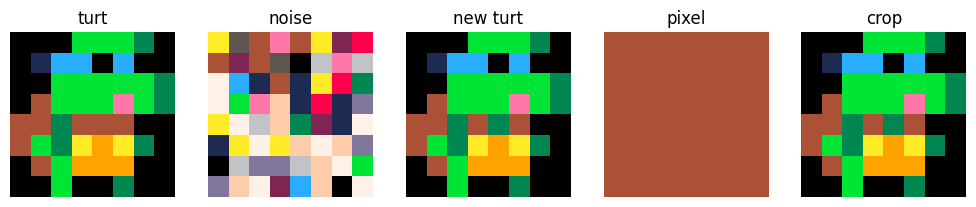

In [50]:
if EXPERIMENT == "normal" and CONFIGS["normal"]["SANITY"]:
    # test destroy function
    turt_spr = pico_char_dat[30]
    n_spr = npod.init_noise_sprite()

    pos = (4,4)
    a,b,c = npod.destroy(turt_spr,n_spr,pos,crop_size=8)
    b2d = np.full((2,2),b)
    print(a.shape)
    print(b2d.shape)
    print(c.shape)

    # showMultiSprPalette([turt_spr,n_spr], ['turt','noise'])
    showMultiSprPalette([turt_spr,n_spr,a,b2d,c],textArr=['turt','noise','new turt','pixel','crop'])


In [ ]:
# test train data creation
if EXPERIMENT == "normal" and CONFIGS["normal"]["SANITY"]:
    turt_spr = pico_char_dat[30]
    tdat = npod.make_train_dat([turt_spr],num_noise_spr=1)
    print(len(tdat))

100%|██████████| 1/1 [00:00<00:00, 288.68it/s]

64


In [ ]:
# test output of the model
if EXPERIMENT == "normal" and CONFIGS["normal"]["SANITY"]:
    turt_spr = pico_char_dat[0].copy()
    turt_spr2 = turt_spr.copy()
    turt_spr2[4,2] = 14
    _,c = npod.crop(turt_spr2,(4,2),5)
    print(c.shape)

    #fix the sprite
    new_px = npod.pod_model.predict(np.array([c]),verbose=False)
    turt_spr3 = np.copy(turt_spr2)
    turt_spr3[4,2] = np.argmax(new_px)

    showMultiSprPalette([turt_spr,turt_spr2,turt_spr3],textArr=['OG','destroy','repair'])

(5, 5)


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/flatten/Reshape' defined at (most recent call last):
    File "/Users/milk/.pyenv/versions/3.8.9/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/milk/.pyenv/versions/3.8.9/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/milk/.pyenv/versions/3.8.9/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/milk/.pyenv/versions/3.8.9/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/milk/.pyenv/versions/3.8.9/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/5h/0zjb1m296y1gvhtd9q40w4yc0000gn/T/ipykernel_87198/307434881.py", line 10, in <module>
      new_px = npod.pod_model.predict(np.array([c]),verbose=False)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/engine/training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
      return self(x, training=False)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/keras/layers/reshaping/flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential/flatten/Reshape'
Input to reshape is a tensor with 1024 values, but the requested shape requires a multiple of 4096
	 [[{{node sequential/flatten/Reshape}}]] [Op:__inference_predict_function_16469]

### TEXT ENCODED PoD

---

#### Notes


